# Overview
 - This notebook includes a case study of loans from Lending Club
 - See all code in [github repository](https://github.com/VivianDang/Lending-Club-loan).

In [33]:
from audioop import mul
from operator import index
from tkinter import Y
import numpy as np
import pandas as pd
from sympy import subsets
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [34]:
loans = pd.read_csv('loans_full_schema.csv')
df = loans.copy()
col = df.columns
target = 'interest_rate'

In [35]:
# useful functions borrowed from Professor Yuxiao Huang
# https://github.com/yuxiaohuang/teaching/blob/master/gwu/machine_learning_I/spring_2022/code/utilities/p2_shallow_learning/pmlm_utilities_shallow.ipynb

# identifier checking
def id_checker(df, dtype='float'):
    """
    The identifier checker

    Parameters
    ----------
    df : dataframe
    dtype : the data type identifiers cannot have, 'float' by default
            i.e., if a feature has this data type, it cannot be an identifier

    Returns
    ----------
    The dataframe of identifiers
    """

    # Get the dataframe of identifiers
    df_id = df[[var for var in df.columns
                # If the data type is not dtype
                if (df[var].dtype != dtype
                    # If the value is unique for each sample
                    and df[var].nunique(dropna=True) == df[var].notnull().sum())]]

    return df_id

# missing values cjecking
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : the dataframe

    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and data type
    """

    # Get the dataframe of variables with NaN, their proportion of NaN and data type
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])

    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)

    return df_nan

# categorical value checking
def cat_var_checker(df, dtype='object'):
    """
    The categorical variable checker

    Parameters
    ----------
    df : the dataframe
    dtype : the data type categorical variables should have, 'object' by default
            i.e., if a variable has this data type, it should be a categorical variable

    Returns
    ----------
    The dataframe of categorical variables and their number of unique value
    """

    # Get the dataframe of categorical variables and their number of unique value
    df_cat = pd.DataFrame([[var, df[var].nunique(dropna=False)]
                           # If the data type is dtype
                           for var in df.columns if df[var].dtype == dtype],
                          columns=['var', 'nunique'])

    # Sort df_cat in accending order of the number of unique value
    df_cat = df_cat.sort_values(by='nunique', ascending=False).reset_index(drop=True)

    return df_cat

# Descriptions
 There are 10000 in original dataset with 55 columns including 13 categorical columns and 42 numerical columns.
 10 columns contains missing values.

In [36]:
# identify ids
print('-'*70)
print('Identifiers Checking: ')
df_id = id_checker(df)
print(df_id.head())
print(f'There are {len(df_id.columns)} identifiers in this dataset.')
print('-'*70)

# identify categorical variables
print('-'*70)
print('Categorical Variables Checking: ')
df_cat = cat_var_checker(df)
print(df_cat)
print(f'There are {len(df_cat)} categorical variables in this dataset.')
print('-'*70)

# identify missing values
print('-'*70)
print('Missing Values Checking: ')
df_nan = nan_checker(df)
print(df_nan)
print(f'There are {len(df_nan)} variables with missing values in this dataset.')
print('-'*70)

----------------------------------------------------------------------
Identifiers Checking: 
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
There are 0 identifiers in this dataset.
----------------------------------------------------------------------
----------------------------------------------------------------------
Categorical Variables Checking: 
                          var  nunique
0                   emp_title     4742
1                       state       50
2                   sub_grade       32
3                loan_purpose       12
4                       grade        7
5                 loan_status        6
6   verification_income_joint        4
7               homeownership        3
8             verified_income        3
9                 issue_month        3
10           application_type        2
11     initial_listing_status        2
12        disbursement_method        2
There are 13 categorical variables in this dataset.
-----------------------------------------

# Handling Missing Values

 Since most of the value missings are caused by associated columns(e.g. joint application and joint annual income),
 we filter those columns out and remove the 'real' missing value

In [37]:
# drop missing values with proportion less than 20%
df.dropna(subset=df_nan['var'][-5:], axis=0, inplace=True)

In [38]:
df_ind = df[df.application_type=='individual'].drop(['verification_income_joint','debt_to_income_joint', 'annual_income_joint'], axis=1)
df_joint = df[df.application_type=='joint']

In [39]:
# identify missing values
print('-'*70)
print('Missing Values Checking: ')
print('-'*50)
print('Individual Application: ')
df_ind_nan = nan_checker(df_ind)
print(df_ind_nan)
print('There are 6 variables with missing values.')
print('-'*50)
print('Joint Application: ')
df_join_nan = nan_checker(df_joint)
print(df_join_nan)
print('There are 7 variables with missing values.')
print('-'*70)

----------------------------------------------------------------------
Missing Values Checking: 
--------------------------------------------------
Individual Application: 
                        var  proportion    dtype
0     months_since_90d_late    0.758626  float64
1  months_since_last_delinq    0.546934  float64
There are 6 variables with missing values.
--------------------------------------------------
Joint Application: 
                         var  proportion    dtype
0      months_since_90d_late    0.818912  float64
1   months_since_last_delinq    0.582516  float64
2  verification_income_joint    0.026762   object
There are 7 variables with missing values.
----------------------------------------------------------------------


In [40]:
# drop missing values with proportion less than 5% in Joint Application
df.drop(index=df_joint.verification_income_joint.isna().index)
df_joint.dropna(subset=['verification_income_joint'], axis=0, inplace=True)

/Users/yuan/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [41]:
# fill joint variables in Individual Application with zero
df[['debt_to_income_joint', 'verification_income_joint', 'annual_income_joint']] = df[['debt_to_income_joint', 'verification_income_joint', 'annual_income_joint']].fillna(0)

# check missing values again
print('-'*70)
print('Missing Values Checking: ')
df_nan = nan_checker(df)
print(df_nan)
print(f'There are {len(df_nan)} variables with missing values in this dataset.')
print('-'*70)

----------------------------------------------------------------------
Missing Values Checking: 
                        var  proportion    dtype
0     months_since_90d_late    0.767337  float64
1  months_since_last_delinq    0.552075  float64
There are 2 variables with missing values in this dataset.
----------------------------------------------------------------------


In [42]:
# months_since_last_delinq is compled with delinq_2y
print('-'*70)
print('Missing Values Checking with no Delinquencies: ')
print('-'*50)
print('Individual Application: ')
df_delin = df[df.delinq_2y!=0]
df_delin_nan = nan_checker(df_delin)
print(df_delin_nan)
print('-'*70)

----------------------------------------------------------------------
Missing Values Checking with no Delinquencies: 
--------------------------------------------------
Individual Application: 
                     var  proportion    dtype
0  months_since_90d_late    0.488564  float64
----------------------------------------------------------------------


In [43]:
# fill months_since_last_delinq with zero for those whose delinq_2y=0
df.loc[df.delinq_2y==0, 'months_since_last_delinq'] = 0

# check missing values again
print('-'*70)
print('Missing Values Checking: ')
df_nan = nan_checker(df)
print(df_nan)
print(f'There are {len(df_nan)} variables with missing values in this dataset.')
print('-'*70)

----------------------------------------------------------------------
Missing Values Checking: 
                     var  proportion    dtype
0  months_since_90d_late    0.767337  float64
There are 1 variables with missing values in this dataset.
----------------------------------------------------------------------


In [44]:
# since there seems to have no variables compled with months_since_90d_late, we just drop this column
df.drop('months_since_90d_late', inplace=True, axis=1)
print('-'*70)
print('Missing Values Checking: ')
df_nan = nan_checker(df)
print(df_nan)
print(f'There are {len(df_nan)} variables with missing values in this dataset.')
print('-'*70)

----------------------------------------------------------------------
Missing Values Checking: 
Empty DataFrame
Columns: [var, proportion, dtype]
Index: []
There are 0 variables with missing values in this dataset.
----------------------------------------------------------------------


In [45]:
# drop unnecessary columns (all zeros)
df.drop(['current_accounts_delinq', 'num_accounts_120d_past_due', 'num_accounts_30d_past_due'], inplace=True, axis=1)
col = df.columns

In [46]:
# save clean dataset
df.to_csv('loan_clean.csv', index=False)

# Visualization

In [47]:
# subsets
df_ind = df[df.application_type=='individual']
df_joint = df[df.application_type=='joint']
df_delin = df[df.delinq_2y!=0]

In [48]:
# calculated columns
df['credit_per_line'] = df.total_credit_limit/df.total_credit_lines
df_ind['loan_income_ratio'] = df_ind.loan_amount/df_ind.annual_income
df_joint['loan_income_ratio'] = df_joint.loan_amount/df_joint.annual_income_joint
df['state'] = pd.Categorical(df['state'], df.state.value_counts().index)
# groups
df_grade_group = df.groupby(df.grade).mean()
df_sub_grade_group = df.groupby(['grade', 'sub_grade']).mean()
df_delinq_group = df_grade_group[df_grade_group.delinq_2y!=0]

<ipython-input-48-a90282175764>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ind['loan_income_ratio'] = df_ind.loan_amount/df_ind.annual_income
<ipython-input-48-a90282175764>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joint['loan_income_ratio'] = df_joint.loan_amount/df_joint.annual_income_joint


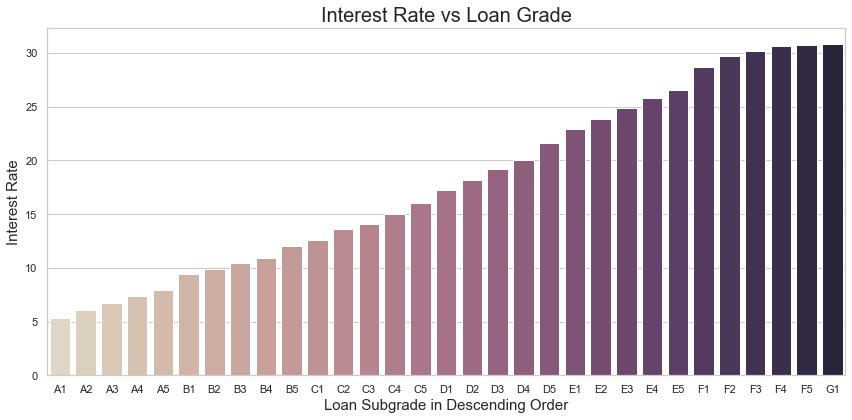

In [49]:
# barplot1
fig = plt.figure(figsize=(12, 6))
sns.barplot(data=df_sub_grade_group, 
            x=df_sub_grade_group.index.get_level_values('sub_grade'),
            y='interest_rate',
            palette="ch:s=-.2,r=.6"
            )
plt.title('Interest Rate vs Loan Grade', fontdict = {'fontsize' : 20})
plt.xlabel('Loan Subgrade in Descending Order', fontdict = {'fontsize' : 15})
plt.ylabel('Interest Rate', fontdict = {'fontsize' : 15})
plt.tight_layout()
plt.show()

 The lower grade has higher interest rate.

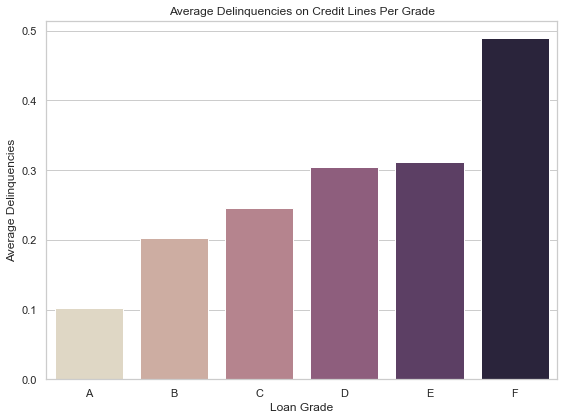

In [50]:
# barplot2
fig = plt.figure(figsize=(8, 6))
sns.barplot(data=df_delinq_group,
            x = df_delinq_group.index,
            y = 'delinq_2y',
            palette="ch:s=-.2,r=.6"
             )
plt.title('Average Delinquencies on Credit Lines Per Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Average Delinquencies')
plt.tight_layout()
plt.show()

 It shows that lower grade loans have higher average delinquencies on credit lines, which means if the applicant has many delinquencies on his credit lines,
 his application may be assigned to higher interest rate.

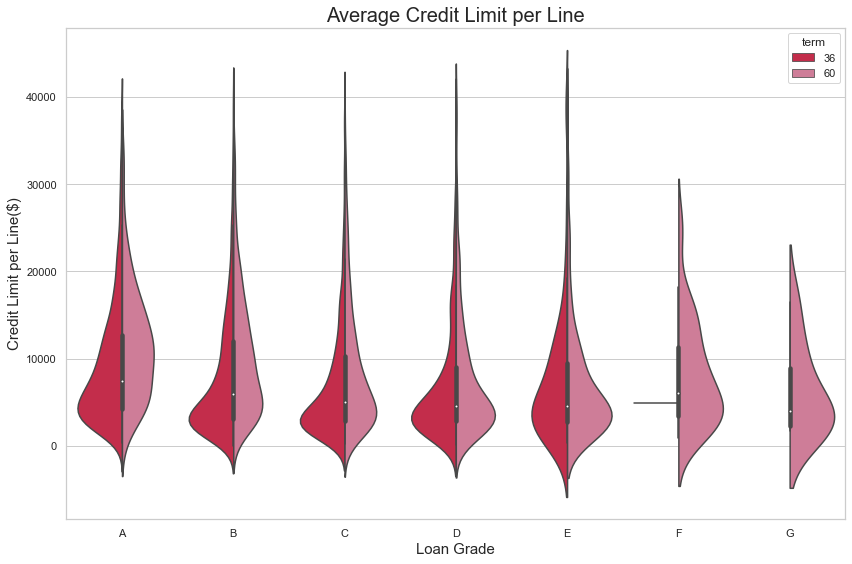

In [51]:
# violinplot
fig = plt.figure(figsize=(12, 8))
sns.violinplot(data=df[df.credit_per_line < 40000],
               x=df.grade.sort_values(),
               y='credit_per_line',
               hue='term',
               split=True,
               palette={36:'crimson', 60:'palevioletred'})
plt.title('Average Credit Limit per Line', fontdict = {'fontsize' : 20})
plt.xlabel('Loan Grade', fontdict = {'fontsize' : 15})
plt.ylabel('Credit Limit per Line($)', fontdict = {'fontsize' : 15})
plt.tight_layout()
plt.show()

 By calculating the average credit limit per credit line of each grade group, lower grade group has lower average credit limit.
 And almost every applicant in group F and G received 60 months of loan.

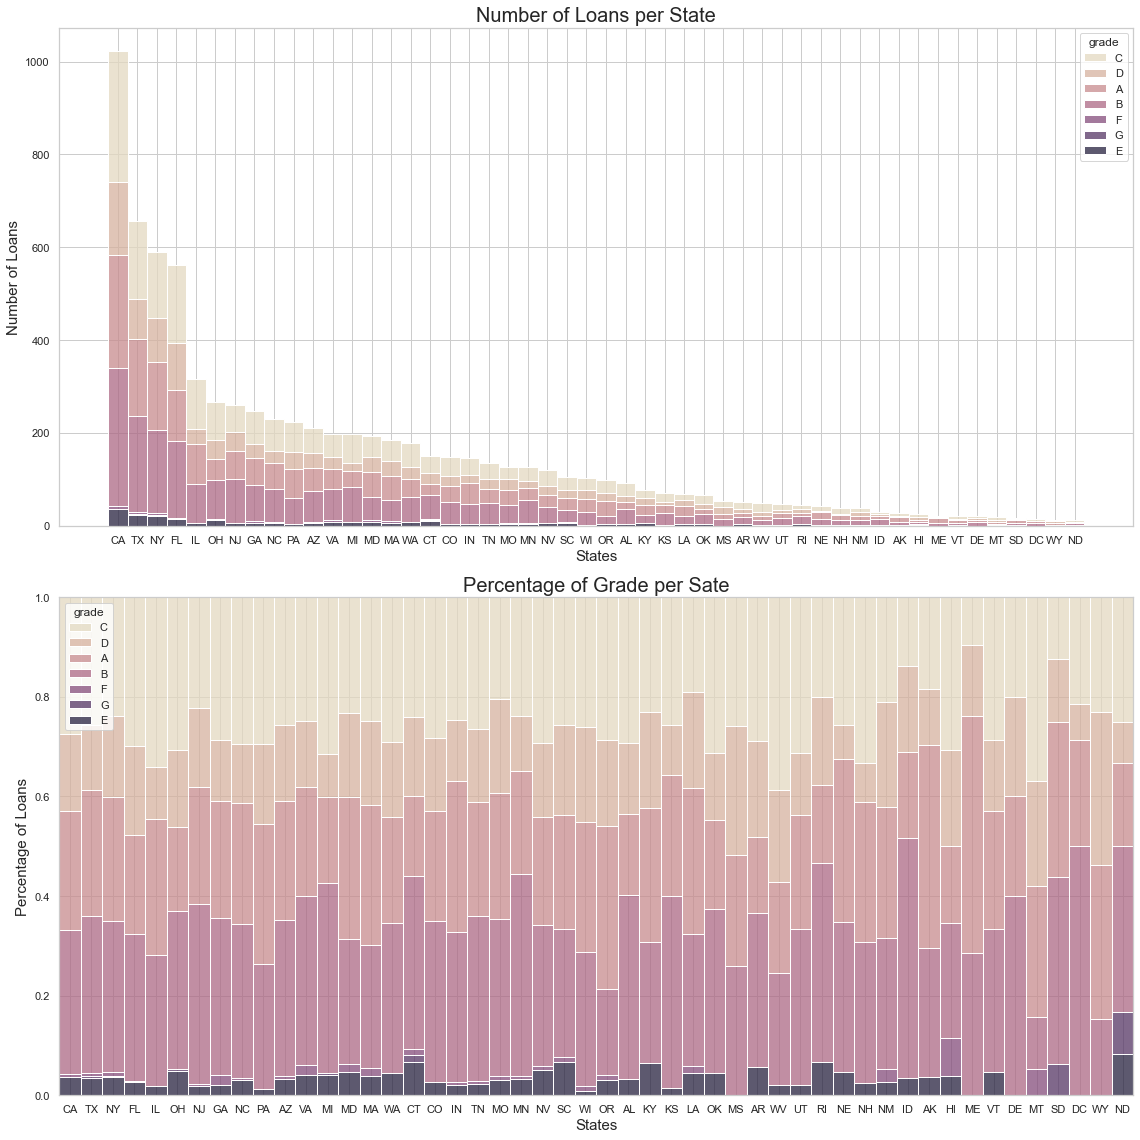

In [52]:
# subplots
fig, ax = plt.subplots(2, 1, figsize=(16, 16))
sns.histplot(data=df,
            x='state',
            hue='grade',
            multiple='stack',
            discrete = True,
            palette="ch:s=-.2,r=.6",
            ax=ax[0]
            )
sns.histplot(data=df,
            x='state',
            hue='grade',
            multiple='fill',
            discrete = True,
            palette="ch:s=-.2,r=.6",
            ax=ax[1]
            )
ax[0].set_title('Number of Loans per State', fontdict = {'fontsize' : 20})
ax[1].set_title('Percentage of Grade per Sate', fontdict = {'fontsize' : 20})
ax[0].set_ylabel('Number of Loans', fontdict = {'fontsize' : 15})
ax[1].set_ylabel('Percentage of Loans', fontdict = {'fontsize' : 15})
ax[0].set_xlabel('States', fontdict = {'fontsize' : 15})
ax[1].set_xlabel('States', fontdict = {'fontsize' : 15})
plt.tight_layout()
plt.show()

 Some states have extremely high loan rate than other states. The four most-loaned-states are CA, TX, NY, FL.
 However, it seems that the applicants' resident state will not affect the interest rate they receive.

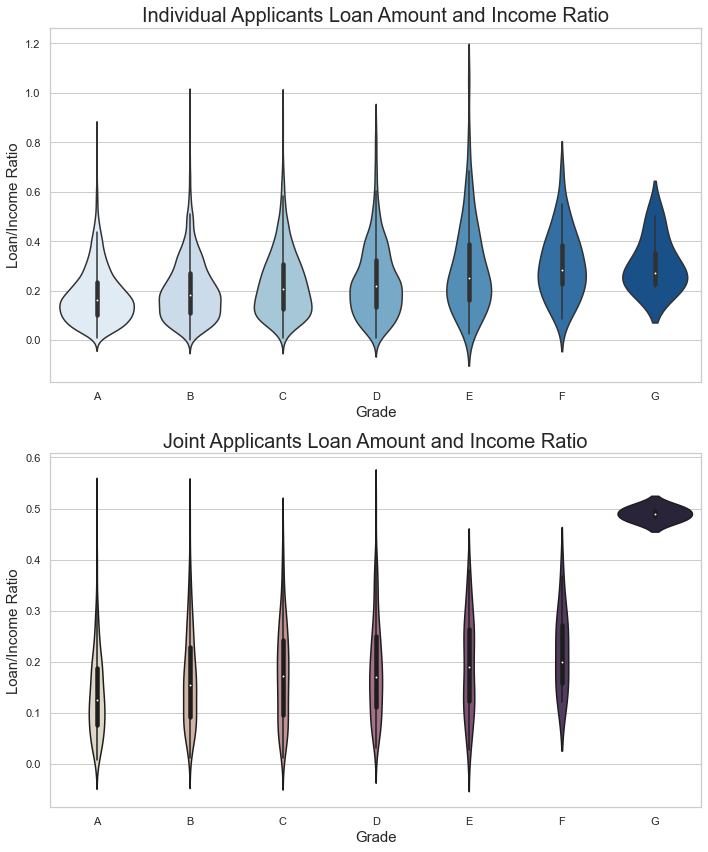

In [53]:
# violin subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
sns.violinplot(data=df_ind,
             x=df_ind.grade.sort_values(),
             y='loan_income_ratio',
             palette='Blues',
             alpha=0.5,
             ax=ax[0]
            #  multiple='dodge',
            #  bins=50,
            #  binwidth=0.5
             )
sns.violinplot(data=df_joint,
             x=df_joint.grade.sort_values(),
             y='loan_income_ratio',
             palette="ch:s=-.2,r=.6",
            #  multiple='dodge',
            #  bins=50,
            #  binwidth=0.5
            alpha=0.5,
            ax=ax[1]
             )
ax[0].set_title('Individual Applicants Loan Amount and Income Ratio', fontdict = {'fontsize' : 20})
ax[1].set_title('Joint Applicants Loan Amount and Income Ratio', fontdict = {'fontsize' : 20})
ax[0].set_ylabel('Loan/Income Ratio', fontdict = {'fontsize' : 15})
ax[1].set_ylabel('Loan/Income Ratio', fontdict = {'fontsize' : 15})
ax[0].set_xlabel('Grade', fontdict = {'fontsize' : 15})
ax[1].set_xlabel('Grade', fontdict = {'fontsize' : 15})
plt.tight_layout()
plt.show()

 Higher loan-income ratio means applicant loans more in consideration of his income.

 It shows that applicants who have higher loan-income ratio will be assigned a lower grade and therefore receive higher interest rate.

In [54]:
# Drop calculated column
df.drop(['credit_per_line', 'state'], axis=1, inplace=True)

# Modeling
 Target: `interest rate`

 Models: `Linear Regression`, `Stochastic Gradient Descent`

 Feature Set: All columns known before applications get approved

In [55]:
# random seed
# The random seed
random_seed = 42

np.random.seed(random_seed)

In [56]:
# Feature set
col = df.columns
feature_set = col[:-14].drop('emp_title')
df_feature = df[feature_set]

In [57]:
# Encoding data
# One-hot-encode the categorical features in the combined data
df_cat = cat_var_checker(df_feature)
print(df_cat)
print(f'There are {len(df_cat)} categorical variables in this dataset.')
df_mod = pd.get_dummies(df_feature, columns=np.setdiff1d(df_cat['var'], [target]))

                         var  nunique
0               loan_purpose       12
1  verification_income_joint        4
2              homeownership        3
3            verified_income        3
4           application_type        2
There are 5 categorical variables in this dataset.


In [58]:
# Splitting data
from sklearn.model_selection import train_test_split

X = df_mod[np.setdiff1d(df_mod.columns, [target])]
Y = df[target]
# Divide the training data into training (80%) and validation (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [59]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

# The MinMaxScaler
mms = MinMaxScaler()
# Normalize the training data
X_train = mms.fit_transform(X_train)

# Normalize the test data
X_test = mms.transform(X_test)

In [60]:
# Linear Regression
from sklearn.linear_model import LinearRegression, SGDRegressor
model1 = LinearRegression()
model1.fit(X_train, Y_train)
Y_pred_train = model1.predict(X_train)
Y_pred_test = model1.predict(X_test)

In [61]:
# Report
from sklearn.metrics import mean_squared_error
print('Coefficients:', model1.coef_)
print('-'*70)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Train Score: %.2f'
      % model1.score(X_train, Y_train))
print('Test Score: %.2f'
      % model1.score(X_test, Y_test))
print('-'*70)

Coefficients: [-3.34120626e+00  4.69245621e+00 -4.48750789e+00 -2.89518171e+00
 -9.44449317e+13 -9.44449317e+13  5.50444708e-01  1.45727441e+01
  3.32929098e+00  6.19384766e+00  9.50195312e-01  3.90625000e-03
 -4.49768726e+13 -4.49768726e+13 -4.49768726e+13  2.15429688e+00
  2.56640625e+00  4.78211360e+13  4.78211360e+13  4.78211360e+13
  4.78211360e+13  4.78211360e+13  4.78211360e+13  4.78211360e+13
  4.78211360e+13  4.78211360e+13  4.78211360e+13  4.78211360e+13
  4.78211360e+13 -1.18359375e+00 -4.68750000e-02  2.99804688e+00
  7.83007812e+00  2.03857422e+00 -1.82677377e+11 -2.25781250e+00
 -1.79101562e+00  4.80468750e+00 -2.13085938e+00 -7.16601562e+00
  1.05390794e+10  1.82677377e+11 -1.60223389e+00 -6.46191406e+00
 -3.35937500e-01  5.84375000e+00 -1.19765625e+01  2.50496127e+13
  2.50496127e+13  2.50496127e+13  2.50496127e+13 -4.27723341e+13
 -4.27723341e+13 -4.27723341e+13]
----------------------------------------------------------------------
Mean squared error (MSE): 18.66
Trai

In [62]:
# SGD Regression
model2 = SGDRegressor(random_state=random_seed)
model2.fit(X_train, Y_train)
Y_pred_train = model2.predict(X_train)
Y_pred_test = model2.predict(X_test)

In [63]:
# Report
print('Coefficients:', model1.coef_)
print('-'*70)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Train Score: %.2f'
      % model2.score(X_train, Y_train))
print('Test Score: %.2f'
      % model2.score(X_test, Y_test))
print('-'*70)

Coefficients: [-3.34120626e+00  4.69245621e+00 -4.48750789e+00 -2.89518171e+00
 -9.44449317e+13 -9.44449317e+13  5.50444708e-01  1.45727441e+01
  3.32929098e+00  6.19384766e+00  9.50195312e-01  3.90625000e-03
 -4.49768726e+13 -4.49768726e+13 -4.49768726e+13  2.15429688e+00
  2.56640625e+00  4.78211360e+13  4.78211360e+13  4.78211360e+13
  4.78211360e+13  4.78211360e+13  4.78211360e+13  4.78211360e+13
  4.78211360e+13  4.78211360e+13  4.78211360e+13  4.78211360e+13
  4.78211360e+13 -1.18359375e+00 -4.68750000e-02  2.99804688e+00
  7.83007812e+00  2.03857422e+00 -1.82677377e+11 -2.25781250e+00
 -1.79101562e+00  4.80468750e+00 -2.13085938e+00 -7.16601562e+00
  1.05390794e+10  1.82677377e+11 -1.60223389e+00 -6.46191406e+00
 -3.35937500e-01  5.84375000e+00 -1.19765625e+01  2.50496127e+13
  2.50496127e+13  2.50496127e+13  2.50496127e+13 -4.27723341e+13
 -4.27723341e+13 -4.27723341e+13]
----------------------------------------------------------------------
Mean squared error (MSE): 18.96
Trai

In [64]:
# Visualize result
model1_train = model1.score(X_train, Y_train)
model1_test = model1.score(X_test, Y_test)
model2_train = model2.score(X_train, Y_train)
model2_test = model2.score(X_test, Y_test)
result = pd.DataFrame({'LinearRegression':[model1_train,model1_test], 'SGDRegression':[model2_train,model2_test]}, index=['train score', 'test score'])
print(result)

             LinearRegression  SGDRegression
train score          0.250761       0.238960
test score           0.294029       0.286144
